In [2]:
import numpy as np
from numpy.typing import NDArray

import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib.lines import Line2D

import superconductivity.api as sc

from superconductivity.api import G_0_muS
from superconductivity.api import NDArray64

from tqdm import tqdm

from nptdms import TdmsFile

from IPython import get_ipython

_ip = get_ipython()
if _ip is not None:
    _ip.run_line_magic("reload_ext", "autoreload")
    _ip.run_line_magic("autoreload", "2")

In [124]:
# file = "/Users/oliver/Documents/measurement data/SSET/22 02b Scheer2/36_9 - unbroken/SCGateMap.tdms"
# file = "/Users/oliver/Documents/measurement data/SSET/22 02b Scheer2/36_9 - unbroken/NCGateMap.tdms"
file = "/Users/oliver/Documents/measurement data/SSET/22 02b Scheer2/65_6/SCMap.tdms"
# file = "/Users/oliver/Documents/measurement data/SSET/22 02b Scheer2/65_6/NCMap.tdms"
# file = "/Users/oliver/Documents/measurement data/SSET/22 03 Scheer2/34/gmap.tdms"
# file = "/Users/oliver/Documents/measurement data/SSET/22 03 Scheer2/36/NC_map.tdms"
file = "/Users/oliver/Documents/measurement data/SSET/22 03 Scheer2/36/SC_map.tdms"

sweep = (24000, 70000)
sweep = (0, None)

nu_downsample_Hz = 37

In [125]:
with TdmsFile.open(file) as f:
    print("File properties:", f.properties)
    for k, v in f.properties.items():
        print(f"  - {k}: {v}")

    for g in f.groups():
        print(f"\nGroup: {g.name}")
        if g.properties:
            for k, v in g.properties.items():
                print(f"  [prop] {k}: {v}")
        for ch in g.channels():
            print(f"  Channel: {ch.name} (len={len(ch)})")
            if ch.properties:
                for k, v in ch.properties.items():
                    print(f"    [prop] {k}: {v}")

File properties: OrderedDict({'name': 'SC_map', 's_time': np.datetime64('2022-03-31T06:52:14.096732'), 's_map_type': 0, 's_map_string': 'Gate Map', 's_resistance': 0.0, 's_file_format': 3, 's_param_flags': 15, 's_ampl_resistor': 102000.0, 's_ampl_sample_dynamic': 0, 's_ampl_sample_high': 0, 's_ampl_sample_low': 6, 's_ampl_sample_filter': 2, 's_ampl_sample_invert': False, 's_ampl_sample_source': 0, 's_ampl_sample_coupling': 1, 's_ampl_sample_gain': 4, 's_ampl_sample_effective_gain': 2000.0, 's_ampl_reference_dynamic': 0, 's_ampl_reference_high': 0, 's_ampl_reference_low': 6, 's_ampl_reference_filter': 2, 's_ampl_reference_invert': False, 's_ampl_reference_source': 0, 's_ampl_reference_coupling': 1, 's_ampl_reference_gain': 2, 's_ampl_reference_effective_gain': 500.0, 's_manget_measure_field': 0.0, 's_manget_measure_current': 0.0, 's_manget_setpoint_field': 0.0, 's_magnet_setpoint_current': 0.0, 's_gate_range': 1.0, 's_gate_en': True, 's_gate_volt': 0.004, 's_source_imp': 3, 's_source_of

In [126]:
keys = []
values = []

with TdmsFile.open(file) as f:
    mkeys = f.groups()
    for mkey in mkeys:
        name = mkey.name
        if name not in ["ZeroOffsetAdjust", "Thermometry", "Mapped"]:
            keys.append(name)
            value = name.split("G")[1].split("V")[0]
            if value[-1] == "m":
                value = float(value[:-1]) * 1e-3
            elif value[-1] == "u":
                value = float(value[:-1]) * 1e-6
            else:
                value = 0
            value = np.round(value, 6)
            values.append(value)

In [127]:
with TdmsFile.open(file) as f:
    amp = (
        f.properties["s_ampl_sample_effective_gain"],
        f.properties["s_ampl_reference_effective_gain"],
    )
    rref = f.properties["s_ampl_resistor"]
    nu_source_Hz = f.properties["s_source_f"]
    dt_sample_s = f[keys[0]].properties["s_dt"]
    nu_sample_Hz = 1 / dt_sample_s
nu_sample_Hz, amp, rref

(5000.0, (2000.0, 500.0), 102000.0)

In [128]:
from superconductivity.utilities.functions import oversample


Sample_V = []
Reference_V = []

dt_downsample_s = 1 / nu_downsample_Hz

with TdmsFile.open(file) as f:
    for i, key in enumerate(keys):
        sample_V = f[key]["Sample"].as_dataframe()
        reference_V = f[key]["Reference"].as_dataframe()
        sample_V = sample_V.values
        reference_V = reference_V.values

        sample_V = sample_V[sweep[0] : sweep[1], 0]
        reference_V = reference_V[sweep[0] : sweep[1], 0]

        time_s = np.arange(len(sample_V)) * dt_sample_s

        nu_time_s = np.arange(0, np.max(time_s), dt_downsample_s)

        nu_sample_V = sc.bin_y_over_x(time_s, sample_V, nu_time_s)
        nu_reference_V = sc.bin_y_over_x(time_s, reference_V, nu_time_s)

        Sample_V.append(nu_sample_V)
        Reference_V.append(nu_reference_V)

V_bias_mV = np.linspace(-1.5, 1.5, 3001)
V_gate_mV = np.array(values, dtype=np.float64) * 1e3

I_nA = np.zeros((V_gate_mV.shape[0], V_bias_mV.shape[0]))

for i, key in enumerate(tqdm(keys)):
    v_mV = Sample_V[i] * 1e3 / amp[0]
    i_nA = Reference_V[i] * 1e9 / (amp[1] * rref)

    (v_mV, i_nA) = sc.oversample(v_mV, i_nA)

    I_nA[i, :] = sc.bin_y_over_x(v_mV, i_nA, V_bias_mV)

dIdV = np.gradient(I_nA, V_bias_mV, axis=1) / G_0_muS

100%|██████████| 81/81 [00:01<00:00, 50.45it/s]


In [129]:
clim = (None, None)
clim = (0.3, 0.5)
# clim = (0, 1)
index = 30

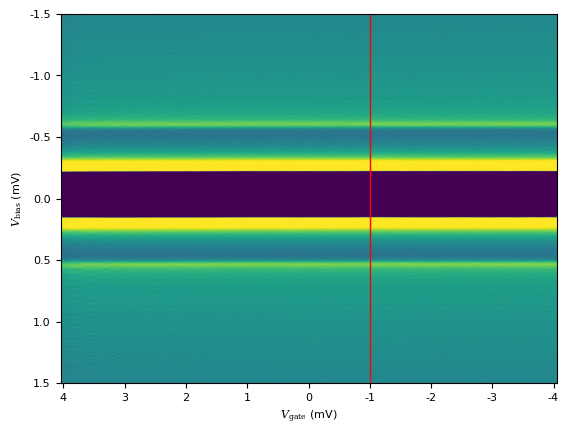

In [130]:
plt.imshow(
    dIdV.T,
    aspect="auto",
    extent=np.flip(sc.get_ext(V_bias_mV, V_gate_mV)),
    clim=clim,
)
plt.xlabel("$V_\\mathrm{gate}$ (mV)")
plt.ylabel("$V_\\mathrm{bias}$ (mV)")
plt.vlines(
    x=V_gate_mV[index], ymin=np.min(V_bias_mV), ymax=np.max(V_bias_mV), color="red"
)

Text(0.5, 0, '$V_\\mathrm{bias}$ (mV)')

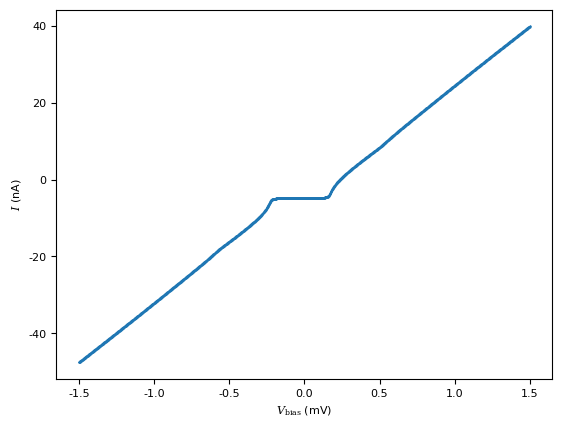

In [131]:
%matplotlib inline
plt.plot(V_bias_mV, I_nA[index, :], ".")
plt.ylabel("$I$ (nA)")
plt.xlabel("$V_\\mathrm{bias}$ (mV)")

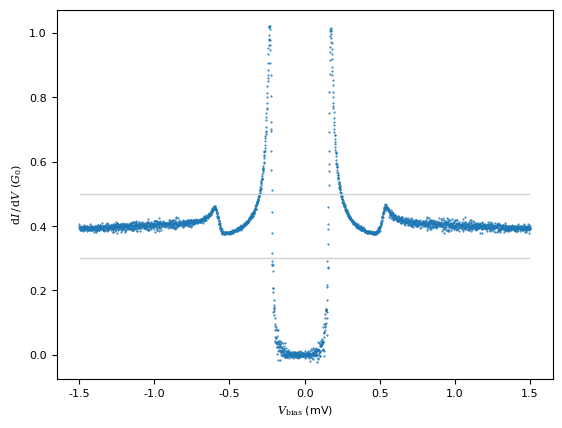

In [132]:
plt.plot(V_bias_mV, dIdV[index, :], ".")
plt.ylabel("$\\mathrm{d}I\\,/\\,\\mathrm{d}V$ ($G_0$)")
plt.xlabel("$V_\\mathrm{bias}$ (mV)")
plt.hlines(y=clim[0], xmin=np.min(V_bias_mV), xmax=np.max(V_bias_mV), color="lightgrey")
plt.hlines(y=clim[1], xmin=np.min(V_bias_mV), xmax=np.max(V_bias_mV), color="lightgrey")